In [56]:
#!pip install leidenalg
#!pip install --user scikit-misc
#!pip install scanpy

import leidenalg
import scanpy as sc
import pandas as pd

In [57]:
# Reading the file and creating an adata object
file = "GSE67835_CPM_named_clean.tsv"
adata = sc.read_text(file, delimiter="\t").T 
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


filtered out 11626 genes that are detected in less than 3 cells
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


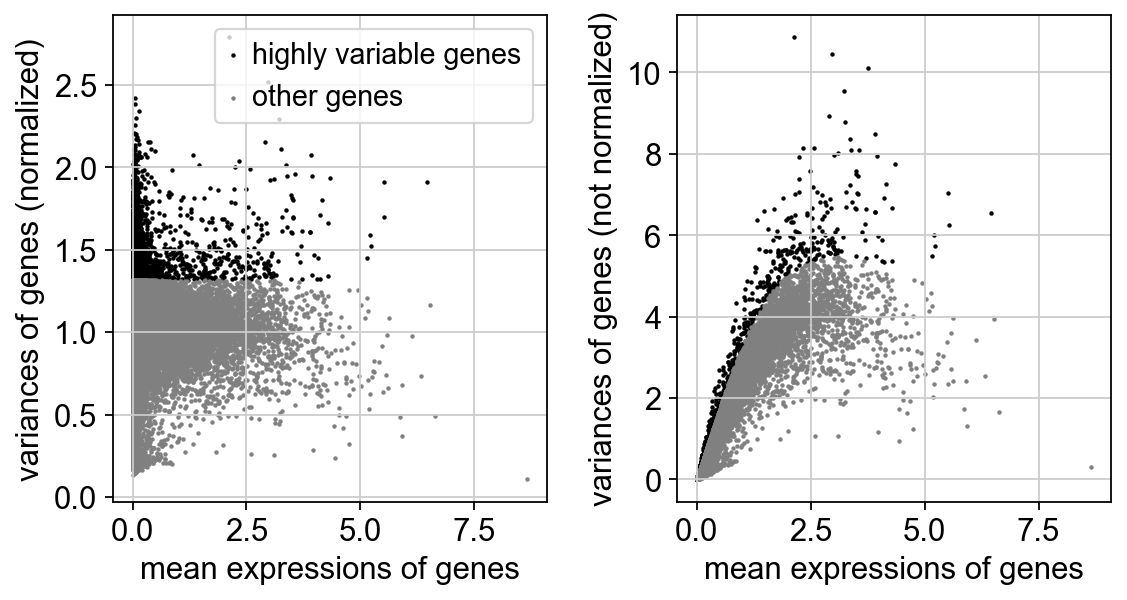

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
A1CF,False,13,1.040758,97.210300,484.993408,13,True,832.0,0.048633,0.176686,1.596410
A2M,False,120,67.567497,74.248927,31486.453125,120,True,626.0,0.819887,3.423236,1.642130
A2M-AS1,False,11,0.990853,97.639485,461.737305,11,True,1295.0,0.048804,0.168748,1.518855
A2MP1,False,43,3.251089,90.772532,1515.007568,43,True,3338.0,0.201627,0.700609,1.351409
AASS,False,236,119.654556,49.356223,55759.023438,236,True,486.0,2.005666,6.427797,1.685910
...,...,...,...,...,...,...,...,...,...,...,...
ZPBP2,False,11,0.744015,97.639485,346.711182,11,True,1007.0,0.047827,0.169830,1.562788
ZSCAN16,False,44,4.897121,90.557940,2282.058350,44,True,2781.0,0.235903,0.846909,1.384552
ZSCAN20,False,20,1.814577,95.708155,845.592834,20,True,1413.0,0.094655,0.342123,1.503756
ZSWIM3,False,16,1.161117,96.566524,541.080566,16,True,2156.0,0.073536,0.247717,1.428865


In [58]:
# Adds a column with a boolean whether a mitochrondrial gene is present
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Remove mitochondrial genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes_list]

# Logarithmize the data matrix.
sc.pp.log1p(adata)

# Filter out low detection genes
sc.pp.filter_genes(adata, min_cells=3)

# Highly variable genes using default calues
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata)
adata.var[adata.var.highly_variable]

In [59]:
# Filtering out the genes that aren't highly variable
adata = adata[:, adata.var.highly_variable]

# Regress out (mostly) unwanted sources of variation.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale data to unit variance and zero mean.
sc.pp.scale(adata, max_value=10)

# Selecting cells that have a % mitochondrial count of less than 10%
adata = adata[adata.obs.pct_counts_mt < 10, :]

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:05)


In [60]:
# Creating a cluster dictionary containing the accession number
cluster_id = {"astrocytes":["SRR1974557","SRR1974604","SRR1974610","SRR1974637","SRR1974641","SRR1974647","SRR1974651","SRR1974653","SRR1974664","SRR1974670","SRR1974672","SRR1974678","SRR1974679","SRR1974682","SRR1974688","SRR1974689","SRR1974692","SRR1974693","SRR1974698","SRR1974699","SRR1974701","SRR1974703","SRR1974715","SRR1974717","SRR1974720","SRR1974721","SRR1974722","SRR1974723","SRR1974725","SRR1974726","SRR1974727","SRR1974728","SRR1974731","SRR1974732","SRR1974733","SRR1974734","SRR1974736","SRR1974737","SRR1974738","SRR1974739","SRR1974740","SRR1974741","SRR1974743","SRR1974744","SRR1974745","SRR1974750","SRR1974751","SRR1974753","SRR1974754","SRR1974814","SRR1974840","SRR1974846","SRR1974856","SRR1974857","SRR1974858","SRR1974859","SRR1974862","SRR1974863","SRR1974865","SRR1974871","SRR1974873","SRR1974874"],
              "endothelial":["SRR1974644","SRR1974665","SRR1974667","SRR1974676","SRR1974755","SRR1974757","SRR1974758","SRR1974761","SRR1974764","SRR1974766","SRR1974768","SRR1974770","SRR1974771","SRR1974772","SRR1974774","SRR1974781","SRR1974784","SRR1974789","SRR1974794","SRR1974798"],
              "fetal_quiescent":["SRR1974675","SRR1974893","SRR1974895","SRR1974897","SRR1974898","SRR1974899","SRR1974901","SRR1974902","SRR1974903","SRR1974904","SRR1974905","SRR1974906","SRR1974907","SRR1974908","SRR1974909","SRR1974910","SRR1974911","SRR1974912","SRR1974913","SRR1974915","SRR1974916","SRR1974917","SRR1974918","SRR1974919","SRR1974920","SRR1974921","SRR1974922","SRR1974923","SRR1974924","SRR1974925","SRR1974926","SRR1974927","SRR1974928","SRR1974929","SRR1974930","SRR1974931","SRR1974932","SRR1974933","SRR1974934","SRR1974935","SRR1974936","SRR1974937","SRR1974938","SRR1974939","SRR1974940","SRR1974941","SRR1974942","SRR1974943","SRR1974944","SRR1974945","SRR1974947","SRR1974948","SRR1974949","SRR1974950","SRR1974951","SRR1974952","SRR1974953","SRR1974954","SRR1974955","SRR1974956","SRR1974957","SRR1974958","SRR1974959","SRR1974960","SRR1974961","SRR1974962","SRR1974963","SRR1974964","SRR1974965","SRR1974966","SRR1974967","SRR1974968","SRR1974969","SRR1974970","SRR1974971","SRR1974972","SRR1974973","SRR1974974","SRR1974975","SRR1974976","SRR1974977","SRR1974978","SRR1974979","SRR1974980","SRR1974981","SRR1974982","SRR1974983","SRR1974984","SRR1974985","SRR1974986","SRR1974987","SRR1974988","SRR1974990","SRR1974991","SRR1974992","SRR1974993","SRR1974994","SRR1974995","SRR1974996","SRR1974998","SRR1974999","SRR1975000","SRR1975001","SRR1975002","SRR1975003","SRR1975004","SRR1975005","SRR1975006","SRR1975007","SRR1975008"],
              "fetal_replicating":["SRR1974875","SRR1974876","SRR1974877","SRR1974878","SRR1974879","SRR1974880","SRR1974881","SRR1974882","SRR1974883","SRR1974884","SRR1974885","SRR1974886","SRR1974887","SRR1974888","SRR1974889","SRR1974890","SRR1974891","SRR1974892","SRR1974894","SRR1974896","SRR1974900","SRR1974914","SRR1974946","SRR1974989","SRR1974997"],
              "hybrid":["SRR1974544","SRR1974546","SRR1974547","SRR1974550","SRR1974551","SRR1974552","SRR1974554","SRR1974555","SRR1974556","SRR1974558","SRR1974559","SRR1974560","SRR1974567","SRR1974568","SRR1974569","SRR1974577","SRR1974584","SRR1974601","SRR1974608","SRR1974619","SRR1974680","SRR1974683","SRR1974685","SRR1974687","SRR1974691","SRR1974694","SRR1974695","SRR1974696","SRR1974700","SRR1974702","SRR1974708","SRR1974716","SRR1974719","SRR1974729","SRR1974742","SRR1974746","SRR1974747","SRR1974748","SRR1974749","SRR1974804","SRR1974816","SRR1974826","SRR1974833","SRR1974837","SRR1974850","SRR1974855"],
              "microglia":["SRR1974582","SRR1974590","SRR1974591","SRR1974595","SRR1974597","SRR1974598","SRR1974599","SRR1974606","SRR1974666","SRR1974668","SRR1974669","SRR1974671","SRR1974788","SRR1974860","SRR1974861","SRR1974868"],
              "neurons":["SRR1974602","SRR1974603","SRR1974605","SRR1974607","SRR1974609","SRR1974611","SRR1974612","SRR1974613","SRR1974614","SRR1974615","SRR1974617","SRR1974618","SRR1974620","SRR1974621","SRR1974622","SRR1974623","SRR1974624","SRR1974625","SRR1974626","SRR1974627","SRR1974628","SRR1974629","SRR1974630","SRR1974631","SRR1974632","SRR1974633","SRR1974634","SRR1974635","SRR1974636","SRR1974638","SRR1974639","SRR1974640","SRR1974642","SRR1974643","SRR1974645","SRR1974646","SRR1974648","SRR1974649","SRR1974650","SRR1974652","SRR1974654","SRR1974655","SRR1974656","SRR1974657","SRR1974658","SRR1974659","SRR1974660","SRR1974661","SRR1974662","SRR1974663","SRR1974673","SRR1974674","SRR1974677","SRR1974681","SRR1974684","SRR1974686","SRR1974697","SRR1974704","SRR1974705","SRR1974706","SRR1974707","SRR1974709","SRR1974710","SRR1974711","SRR1974712","SRR1974713","SRR1974714","SRR1974718","SRR1974724","SRR1974730","SRR1974735","SRR1974752","SRR1974756","SRR1974759","SRR1974762","SRR1974763","SRR1974767","SRR1974773","SRR1974775","SRR1974776","SRR1974777","SRR1974778","SRR1974779","SRR1974780","SRR1974782","SRR1974783","SRR1974785","SRR1974786","SRR1974787","SRR1974793","SRR1974799","SRR1974800","SRR1974801","SRR1974803","SRR1974806","SRR1974807","SRR1974808","SRR1974809","SRR1974810","SRR1974811","SRR1974813","SRR1974815","SRR1974817","SRR1974818","SRR1974819","SRR1974820","SRR1974821","SRR1974822","SRR1974823","SRR1974824","SRR1974825","SRR1974828","SRR1974830","SRR1974832","SRR1974835","SRR1974838","SRR1974841","SRR1974842","SRR1974843","SRR1974844","SRR1974847","SRR1974848","SRR1974849","SRR1974853","SRR1974854","SRR1974864","SRR1974866","SRR1974867","SRR1974869","SRR1974870","SRR1974872"],
              "oligodendrocytes":["SRR1974543","SRR1974545","SRR1974548","SRR1974549","SRR1974553","SRR1974561","SRR1974562","SRR1974563","SRR1974564","SRR1974566","SRR1974570","SRR1974571","SRR1974572","SRR1974573","SRR1974574","SRR1974616","SRR1974690","SRR1974760","SRR1974765","SRR1974769","SRR1974790","SRR1974791","SRR1974792","SRR1974795","SRR1974796","SRR1974797","SRR1974802","SRR1974805","SRR1974812","SRR1974827","SRR1974829","SRR1974831","SRR1974834","SRR1974836","SRR1974839","SRR1974845","SRR1974851","SRR1974852"],
              "OPC":["SRR1974565","SRR1974575","SRR1974576","SRR1974578","SRR1974579","SRR1974580","SRR1974581","SRR1974583","SRR1974585","SRR1974586","SRR1974587","SRR1974588","SRR1974589","SRR1974592","SRR1974593","SRR1974594","SRR1974596","SRR1974600"]
}

In [61]:
# Using dictionary comprehension and pandas.Series.map() method
adata.obs["cluster_tsne"] =  adata.obs.index.map({item: k for k, v in cluster_id.items() for item in v})
adata.obs["cluster_tsne"]=adata.obs["cluster_tsne"].astype(str)

# Checking the number of members post filtering
category_records = adata.obs["cluster_tsne"].value_counts()

# Removing cluster if less than one member is found
for category in category_records.index:
    if category_records[category] < 2:
        adata = adata[adata.obs["cluster_tsne"] != category, :]
        
category_records

/tmp/ipykernel_189689/2629602976.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cluster_tsne"] =  adata.obs.index.map({item: k for k, v in cluster_id.items() for item in v})


cluster_tsne
fetal_quiescent      108
neurons               99
astrocytes            52
oligodendrocytes      37
hybrid                35
fetal_replicating     24
OPC                   18
microglia             15
endothelial           15
Name: count, dtype: int64

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/li

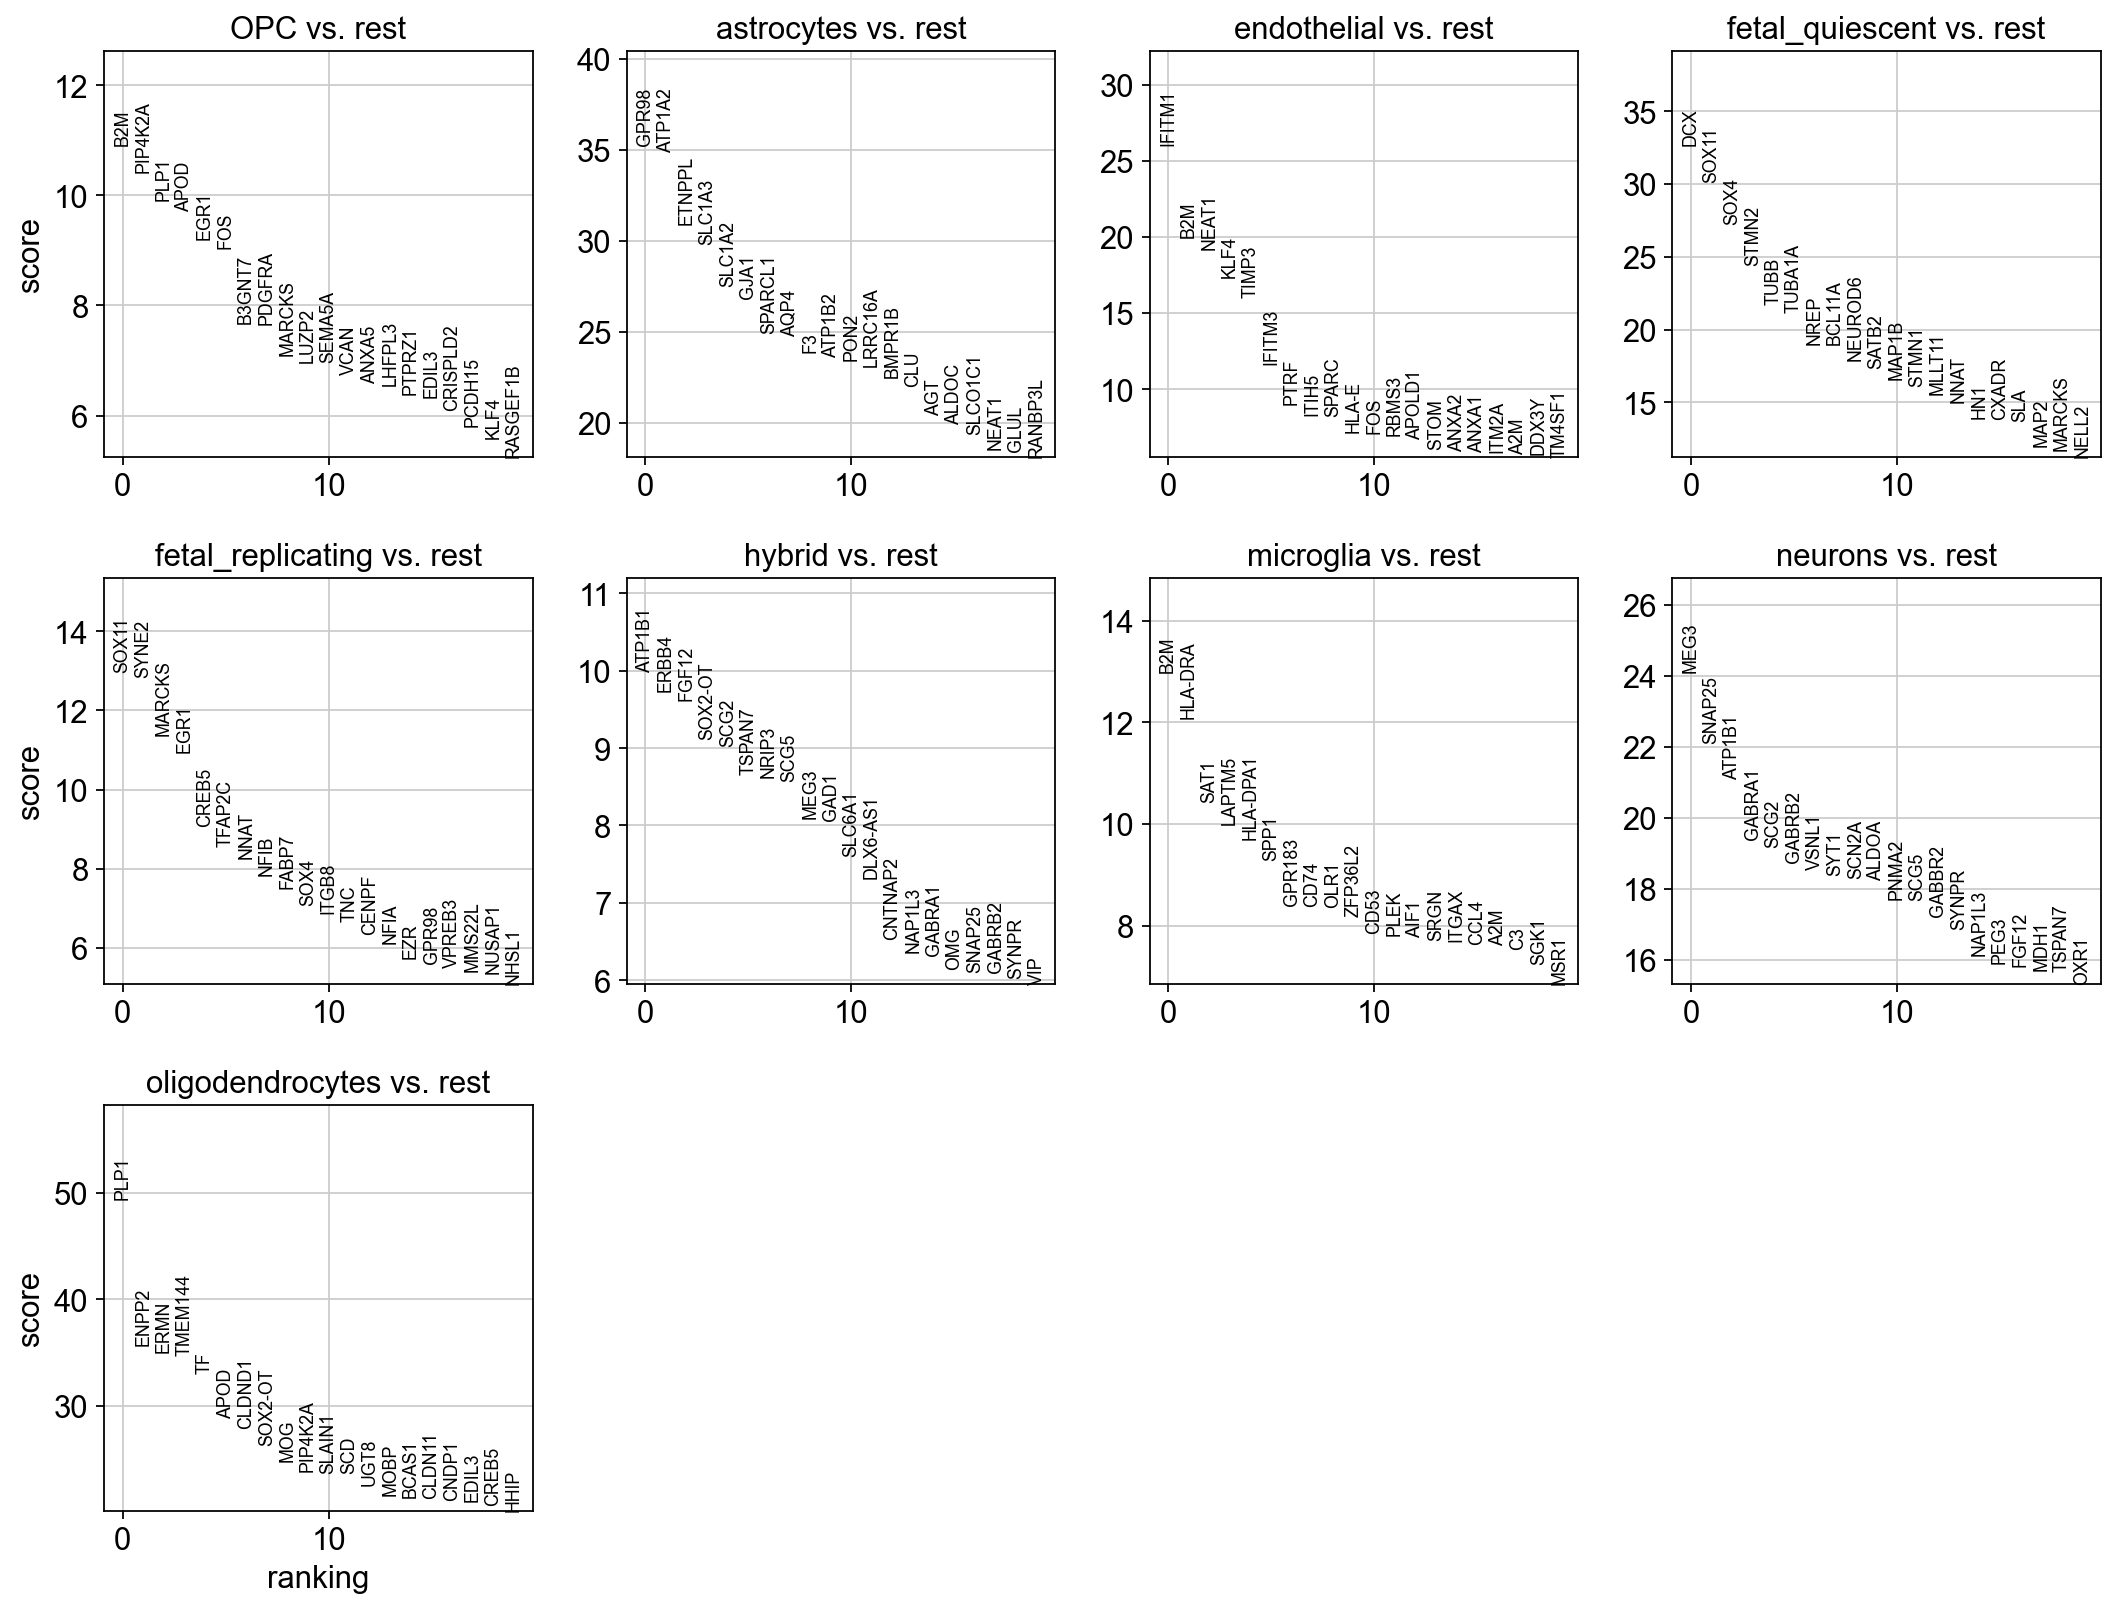

In [62]:
# Find the top 20 gene enrichment for each cluster
sc.tl.rank_genes_groups(adata, groupby="cluster_tsne", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [63]:
# Identify highly correlated and significantly overexpressed gene
markers = sc.get.rank_genes_groups_df(adata, None)
markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]

,group,names,scores,logfoldchanges,pvals,pvals_adj
2665,OPC,RP11-810D13.1,-2.386776,3.447394,0.017469,0.049598
2666,OPC,RNU6-145P,-2.386855,3.372579,0.017471,0.049598
2667,OPC,AC015726.1,-2.387430,4.986137,0.017445,0.049594
2668,OPC,AC079834.2,-2.387875,2.415892,0.017417,0.049551
2672,OPC,RP11-384P7.7,-2.391373,3.971808,0.017263,0.049216
...,...,...,...,...,...,...
35680,oligodendrocytes,DLGAP5,-4.081056,7.174126,0.000054,0.000526
35682,oligodendrocytes,AJUBA,-4.100616,3.104420,0.000050,0.000492
35687,oligodendrocytes,LINC00865,-4.152806,6.446303,0.000040,0.000403
35737,oligodendrocytes,RP11-24B19.3,-4.428793,4.207842,0.000012,0.000144


In [64]:
# comparing original pipeline and alternative pipeline tsne clusters
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15)
sc.tl.tsne(adata)
sc.tl.leiden(adata, resolution=1.2)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 15
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [65]:
# Sample identifer by Lois
sra_table = pd.read_csv("SraRunTable.txt")

samples = {}
for index, sample in enumerate(sra_table.experiment_sample_name):
    samples.setdefault(sample, []).append(sra_table.Run[index])
    
adata.obs['sample_identifier'] = False

for index, row in enumerate(adata.obs_names):
    for key, value in samples.items():
        if row in value:
            adata.obs.sample_identifier.iloc[index] = key

adata.obs

/tmp/ipykernel_189689/2027233335.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.sample_identifier.iloc[index] = key


,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cluster_tsne,leiden,sample_identifier
SRR1974543,5019,459318.21875,18652.886719,4.060995,oligodendrocytes,5,AB_S8
SRR1974545,3734,371827.21875,15834.530273,4.258572,oligodendrocytes,5,AB_S8
SRR1974546,4636,237045.28125,10817.853516,4.563623,hybrid,0,AB_S8
SRR1974548,5466,258048.53125,18724.302734,7.256117,oligodendrocytes,4,AB_S8
SRR1974549,4136,467429.71875,20668.378906,4.421709,oligodendrocytes,5,AB_S8
...,...,...,...,...,...,...,...
SRR1975003,2717,343703.71875,12892.471680,3.751042,fetal_quiescent,3,FB_S6
SRR1975004,3587,460500.56250,9480.000000,2.058629,fetal_quiescent,1,FB_S6
SRR1975005,3371,332652.68750,12795.411133,3.846478,fetal_quiescent,1,FB_S6
SRR1975007,4717,353050.87500,5691.477539,1.612084,fetal_quiescent,1,FB_S6


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


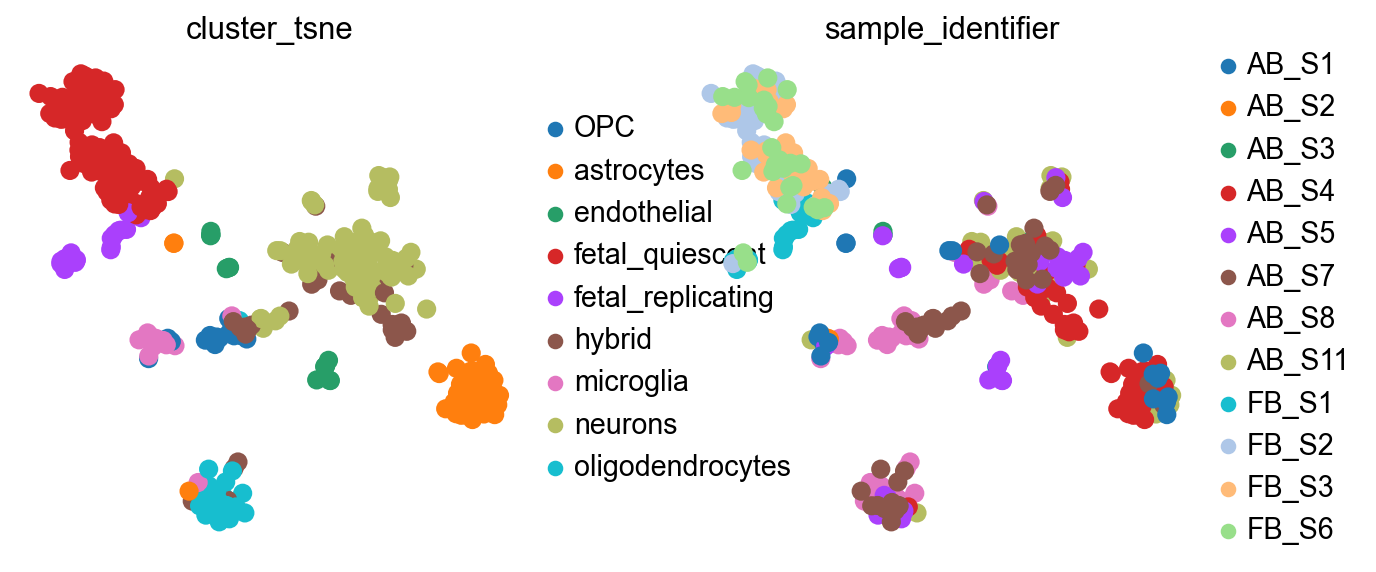

In [66]:
sc.pl.tsne(adata, color = ["cluster_tsne","sample_identifier"], frameon = False,)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yyl23/miniconda3/li

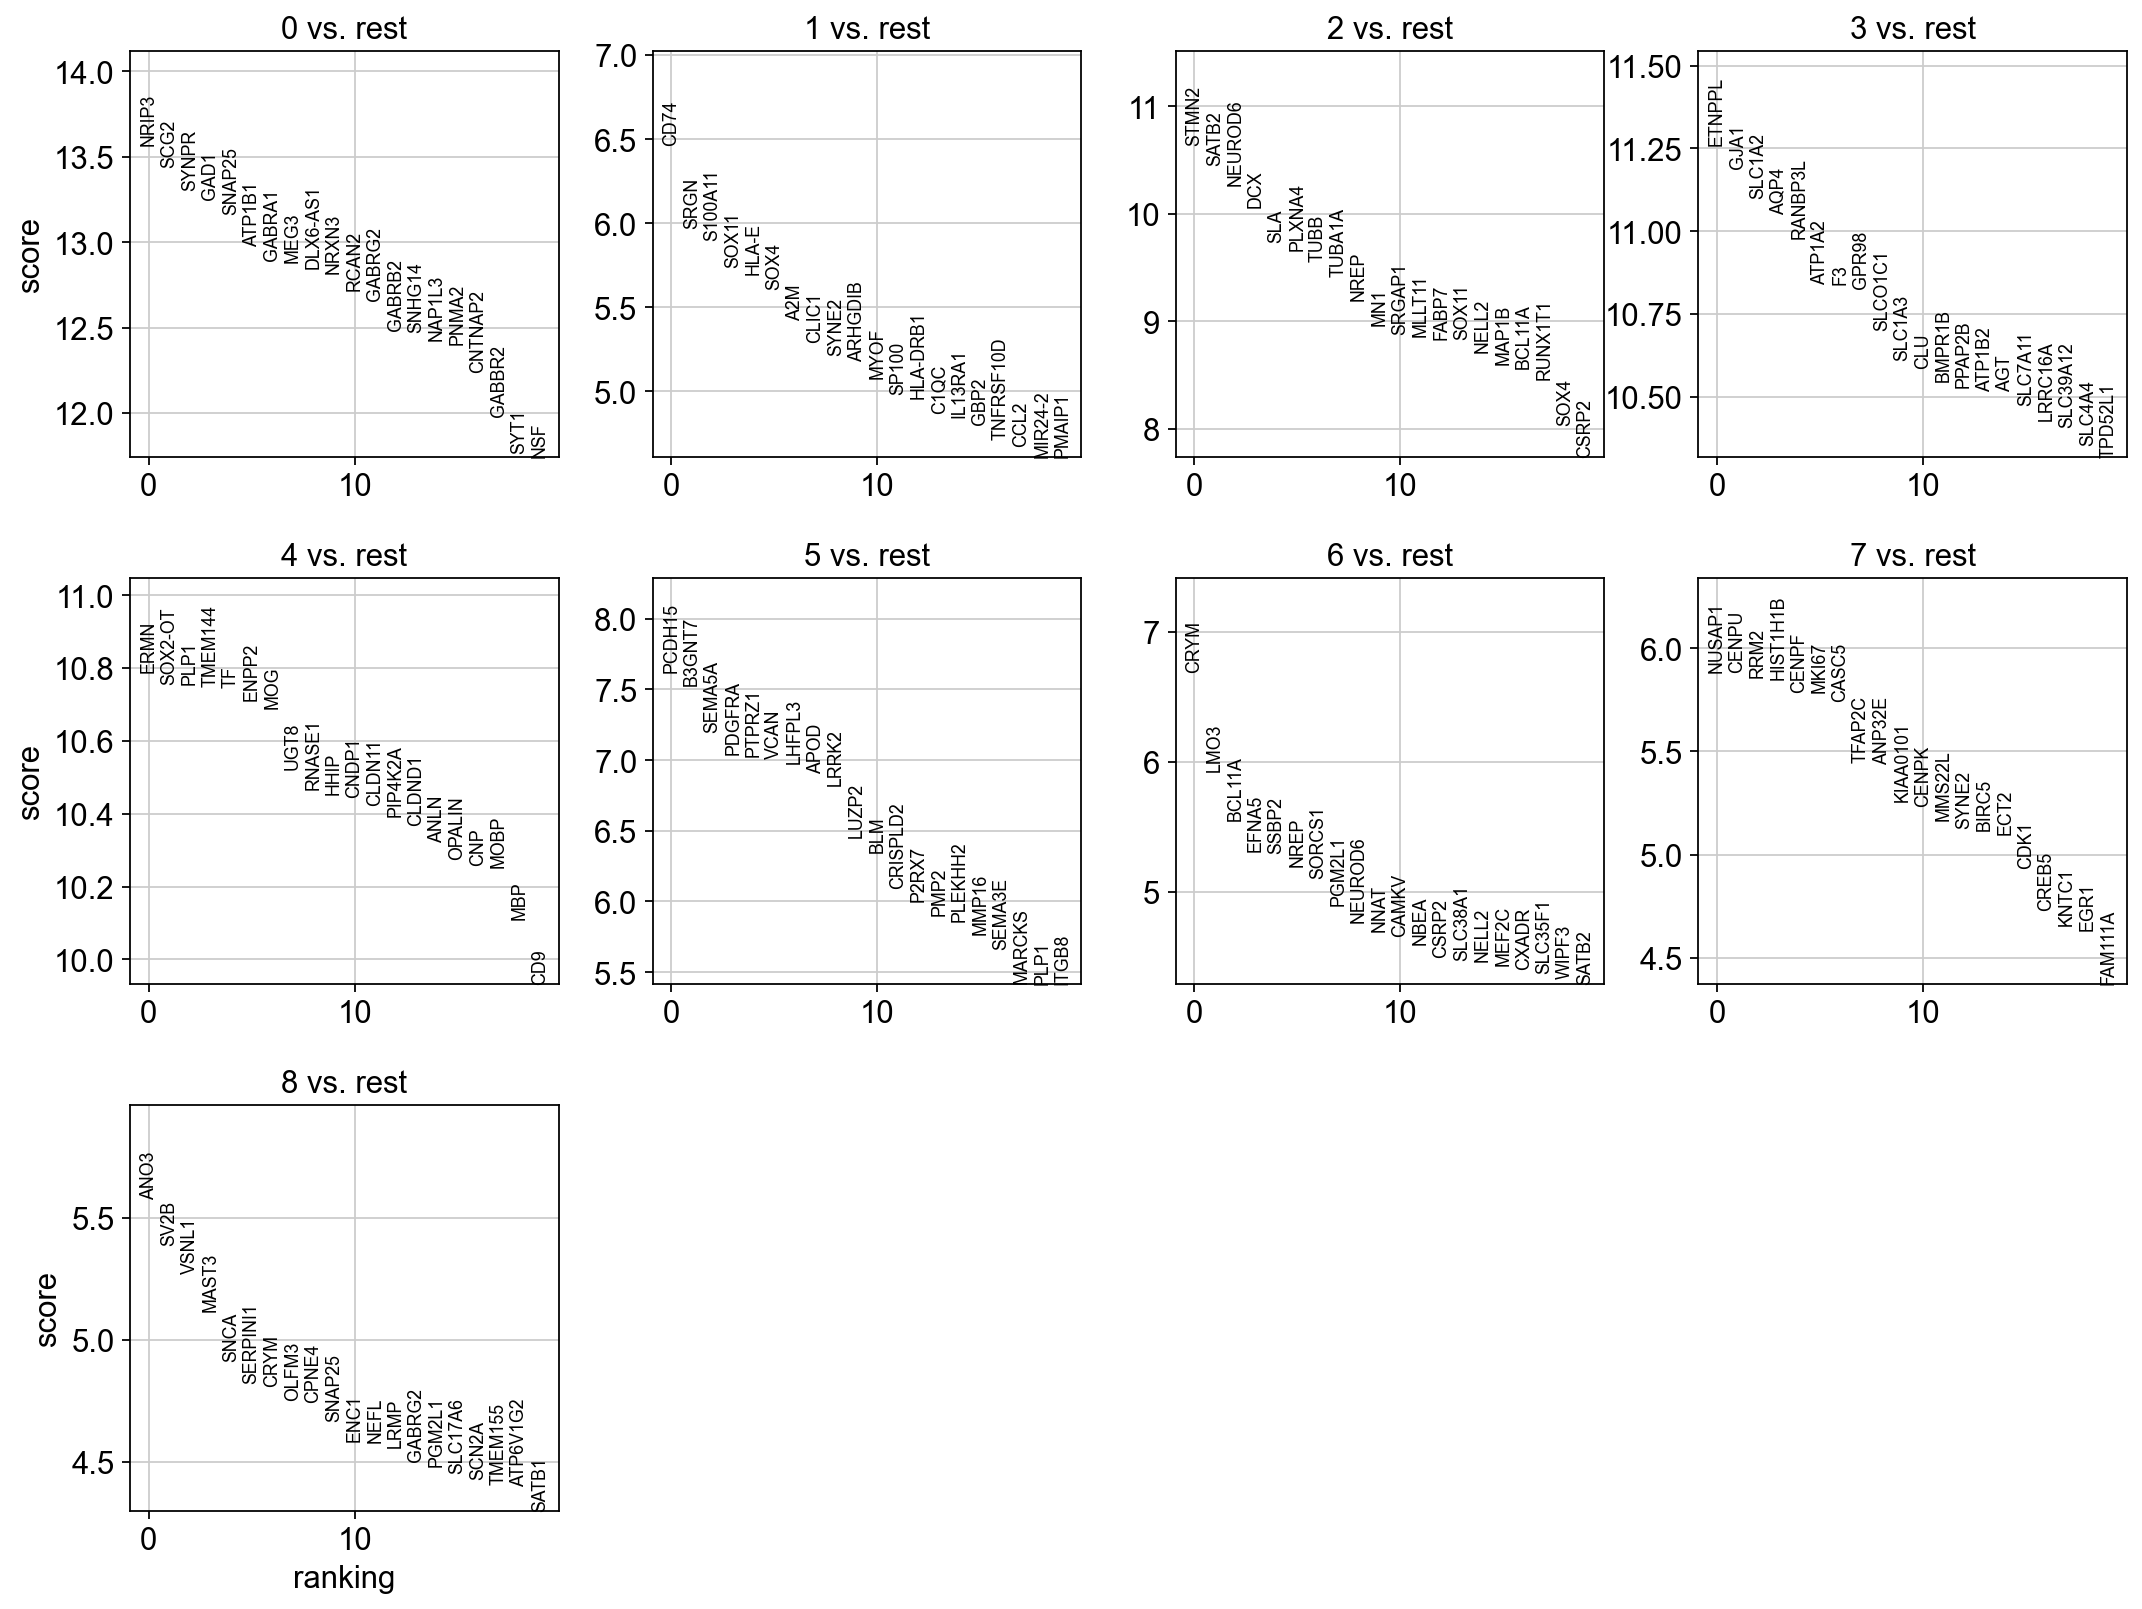

In [42]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

/home/yyl23/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


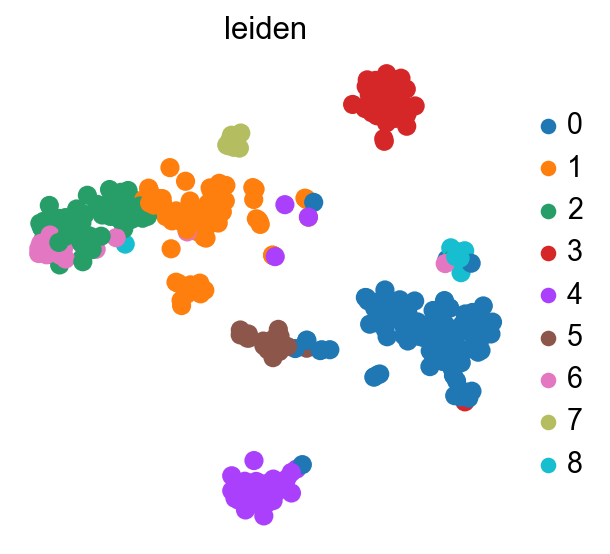

In [44]:
sc.pl.tsne(adata, color = ["leiden"], frameon = False,)

In [ ]:
# mapping cell type found at alternative pipeline
cell_type = {"0":"GABAergic neurons/Interneurons",
"1":"Dendrituc cells, Monocytes, Macrophages",
"2":"Developing neurons",
"3":"Astrocytes",
"4":"Oligodendrocytes",
"5":"Pyramidal cells",
"6":"Oligodendrocyte Progenitor Cells(OPCs)",
"7":"Cortical neurons",
"8":"Interneurons",
"9":"Radial glial cells/Neural Progenitor cells",
    }
adata.obs["cell type"] = adata.obs.leiden.map(cell_type)

In [ ]:
sc.pl.tsne(adata, color = ["cluster_tsne", "cell type"], frameon = False,)